## Creating a logistic regression model in Python!

In [1]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

C:\Users\evans\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Summary of specific ride IDs:

In [3]:
#Make sure the ride_id and the footage file match up:
ride_ids = ['15692']
footage_file = '../../Labelled_Footage/Footage3.txt'


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!

## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [4]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
                                                  Time  IMU A1  IMU A2  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789000+00:00  1.414743e+09   493.0    48.0   
        2018-11-09 19:16:03.822000+00:00           NaN     NaN     NaN   
        2018-11-09 19:16:03.855000+00:00           NaN     NaN     NaN   
        2018-11-09 19:16:03.888000+00:00           NaN     NaN     NaN   
        2018-11-09 19:16:03.921000+00:00           NaN     NaN     NaN   
...                                                ...     ...     ...   
        2018-11-09 20:38:14.946000+00:00           NaN     NaN     NaN   
        2018-11-09 20:38:14.979000+00:00           NaN     NaN     NaN   
        2018-11-09 20:38:15.012000+00:00           NaN     NaN     NaN   
        2018-11-

## Drop the NA values from the dataframe:

In [5]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                                  Time  IMU A1  IMU A2  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789000+00:00  1.414743e+09   493.0    48.0   
        2018-11-09 19:16:04.053000+00:00  1.414743e+09   513.0    89.0   
        2018-11-09 19:16:04.284000+00:00  1.414743e+09   494.0    92.0   
        2018-11-09 19:16:04.548000+00:00  1.414744e+09   421.0   205.0   
        2018-11-09 19:16:04.812000+00:00  1.414744e+09   534.0   306.0   
...                                                ...     ...     ...   
        2018-11-09 20:38:14.055000+00:00  1.419643e+09   501.0   -11.0   
        2018-11-09 20:38:14.319000+00:00  1.419644e+09   501.0   -11.0   
        2018-11-09 20:38:14.583000+00:00  1.419644e+09   502.0   -11.0   
        2018-11-09 20:38:14.814000+00:00  1.419644e+09   501.0   -13.0   
        2018-11-09 20:38:15.078000+00:00  1.419644e+09   501.0   -11.0   

                                     

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [6]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789000+00:00  1.414743e+09   493.0    48.0   
        2018-11-09 19:16:04.053000+00:00  1.414743e+09   513.0    89.0   
        2018-11-09 19:16:04.284000+00:00  1.414743e+09   494.0    92.0   
        2018-11-09 19:16:04.548000+00:00  1.414744e+09   421.0   205.0   
        2018-11-09 19:16:04.812000+00:00  1.414744e+09   534.0   306.0   
        2018-11-09 19:16:05.043000+00:00  1.414744e+09   455.0   149.0   
        2018-11-09 19:16:05.307000+00:00  1.414744e+09   474.0   342.0   
        2018-11-09 19:16:05.571000+00:00  1.414745e+09   363.0   323.0   
        2018-11-09 19:16:05.802000+00:00  1.414745e+09   -21.0   510.0   
        2018-11-09 19:16:06.066000+00:00  1.414745e+09    35.0   283.0   

                                          IMU A3  IMU G1  IMU G2  IMU G3  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789000+00:00   110.0    75.0  -124.0   -86.0   
        2018-11-09 19:16:04.053000+00:00    62.0    34.0   -36.0   -92.0   
        2018-11-09 19:16:04.284000+00:00    80.0    69.0   -63.0   -42.0   
        2018-11-09 19:16:04.548000+00:00  -104.0   192.0   -92.0   -37.0   
        2018-11-09 19:16:04.812000+00:00   -32.0  -421.0  -233.0  -229.0   
        2018-11-09 19:16:05.043000+00:00  -102.0  -355.0  -376.0  -397.0   
        2018-11-09 19:16:05.307000+00:00  -219.0  -234.0  -527.0  -465.0   
        2018-11-09 19:16:05.571000+00:00  -131.0    60.0  -662.0  -305.0   
        2018-11-09 19:16:05.802000+00:00  -447.0    78.0  -643.0  -153.0   
        2018-11-09 19:16:06.066000+00:00  -132.0  -114.0  -430.0   132.0   

                                          IMU M1  IMU M2  IMU M3  TimeDelta  
ride_id UTC                                                                  
15692   2018-11-09 19:16:03.789000+00:00  -309.0   209.0    39.0        0.0  
        2018-11-09 19:16:04.053000+00:00  -320.0   194.0    38.0      252.5  
        2018-11-09 19:16:04.284000+00:00  -329.0   189.0    49.0      501.5  
        2018-11-09 19:16:04.548000+00:00  -330.0   180.0    64.0      753.5  
        2018-11-09 19:16:04.812000+00:00  -325.0   161.0    97.0     1003.5  
        2018-11-09 19:16:05.043000+00:00  -337.0   117.0   151.0     1253.5  
        2018-11-09 19:16:05.307000+00:00  -311.0    25.0   217.0     1504.5  
        2018-11-09 19:16:05.571000+00:00  -238.0    -8.0   272.0     1755.5  
        2018-11-09 19:16:05.802000+00:00  -159.0   -21.0   321.0     2006.5  
        2018-11-09 19:16:06.066000+00:00   -86.0   -38.0   326.0     2258.5

## Footage sync code written by Alina:

In [7]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

In [8]:
motion_df_simple = label_data(footage_file)
motion_df_simple.head(10)

Time  IMU A1  IMU A2  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789000+00:00  1.414743e+09   493.0    48.0   
        2018-11-09 19:16:04.053000+00:00  1.414743e+09   513.0    89.0   
        2018-11-09 19:16:04.284000+00:00  1.414743e+09   494.0    92.0   
        2018-11-09 19:16:04.548000+00:00  1.414744e+09   421.0   205.0   
        2018-11-09 19:16:04.812000+00:00  1.414744e+09   534.0   306.0   
        2018-11-09 19:16:05.043000+00:00  1.414744e+09   455.0   149.0   
        2018-11-09 19:16:05.307000+00:00  1.414744e+09   474.0   342.0   
        2018-11-09 19:16:05.571000+00:00  1.414745e+09   363.0   323.0   
        2018-11-09 19:16:05.802000+00:00  1.414745e+09   -21.0   510.0   
        2018-11-09 19:16:06.066000+00:00  1.414745e+09    35.0   283.0   

                                          IMU A3  IMU G1  IMU G2  IMU G3  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789000+00:00   110.0    75.0  -124.0   -86.0   
        2018-11-09 19:16:04.053000+00:00    62.0    34.0   -36.0   -92.0   
        2018-11-09 19:16:04.284000+00:00    80.0    69.0   -63.0   -42.0   
        2018-11-09 19:16:04.548000+00:00  -104.0   192.0   -92.0   -37.0   
        2018-11-09 19:16:04.812000+00:00   -32.0  -421.0  -233.0  -229.0   
        2018-11-09 19:16:05.043000+00:00  -102.0  -355.0  -376.0  -397.0   
        2018-11-09 19:16:05.307000+00:00  -219.0  -234.0  -527.0  -465.0   
        2018-11-09 19:16:05.571000+00:00  -131.0    60.0  -662.0  -305.0   
        2018-11-09 19:16:05.802000+00:00  -447.0    78.0  -643.0  -153.0   
        2018-11-09 19:16:06.066000+00:00  -132.0  -114.0  -430.0   132.0   

                                          IMU M1  IMU M2  IMU M3  TimeDelta  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:03.789000+00:00  -309.0   209.0    39.0        0.0   
        2018-11-09 19:16:04.053000+00:00  -320.0   194.0    38.0      252.5   
        2018-11-09 19:16:04.284000+00:00  -329.0   189.0    49.0      501.5   
        2018-11-09 19:16:04.548000+00:00  -330.0   180.0    64.0      753.5   
        2018-11-09 19:16:04.812000+00:00  -325.0   161.0    97.0     1003.5   
        2018-11-09 19:16:05.043000+00:00  -337.0   117.0   151.0     1253.5   
        2018-11-09 19:16:05.307000+00:00  -311.0    25.0   217.0     1504.5   
        2018-11-09 19:16:05.571000+00:00  -238.0    -8.0   272.0     1755.5   
        2018-11-09 19:16:05.802000+00:00  -159.0   -21.0   321.0     2006.5   
        2018-11-09 19:16:06.066000+00:00   -86.0   -38.0   326.0     2258.5   

                                          PADDLING  FLOATING  SURFING  WALKING  
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789000+00:00         0         0        0        0  
        2018-11-09 19:16:04.053000+00:00         0         0        0        0  
        2018-11-09 19:16:04.284000+00:00         0         0        0        0  
        2018-11-09 19:16:04.548000+00:00         0         0        0        0  
        2018-11-09 19:16:04.812000+00:00         0         0        0        0  
        2018-11-09 19:16:05.043000+00:00         0         0        0        0  
        2018-11-09 19:16:05.307000+00:00         0         0        0        0  
        2018-11-09 19:16:05.571000+00:00         0         0        0        0  
        2018-11-09 19:16:05.802000+00:00         0         0        0        0  
        2018-11-09 19:16:06.066000+00:00         0         0        0        0

In [9]:
#motion_df_complex = label_data('Footage3.txt', 'complex')
#motion_df_complex.head(10)

## Concatenate multiple footage files that we have so far to create a larger mass of data samples. 

In [10]:
#df1_complex = label_data('Footage.txt', 'complex')
#df2_complex = label_data('Footage2.txt', 'complex')
#df3_complex = label_data('Footage3.txt', 'complex')
#df4_complex = label_data('Footage4.txt', 'complex')

#df_concatenated = pd.concat([df1_complex, df2_complex, df3_complex, df4_complex])

#print("Shape of first dataframe:", df1_complex.shape)
#print("Shape of all combined dataframes:", df_concatenated.shape)

#print("Printing dataframe...")
##print(df1_complex.head(10))
#print(df_concatenated.head(10))

### Convert the Raw IMU data values to real units:

In [11]:
##correct IMU data

##make a deep copy of motion_df_labelled
#df_converted = motion_df_complex.copy(deep = 'true')
df_converted = motion_df_simple.copy(deep = 'true')


##for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= -0.019141  #forwards/backwards
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141   #upside down/right side up
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141   #sideways: negative = left, positive = right
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2        #roll
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2        #yaw
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2        #pitch (flipping forwards/backwards)


In [12]:
df_converted.head(10)

Time     IMU A1    IMU A2  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:03.789000+00:00  1.414743e+09  -9.436513  0.918768   
        2018-11-09 19:16:04.053000+00:00  1.414743e+09  -9.819333  1.703549   
        2018-11-09 19:16:04.284000+00:00  1.414743e+09  -9.455654  1.760972   
        2018-11-09 19:16:04.548000+00:00  1.414744e+09  -8.058361  3.923905   
        2018-11-09 19:16:04.812000+00:00  1.414744e+09 -10.221294  5.857146   
        2018-11-09 19:16:05.043000+00:00  1.414744e+09  -8.709155  2.852009   
        2018-11-09 19:16:05.307000+00:00  1.414744e+09  -9.072834  6.546222   
        2018-11-09 19:16:05.571000+00:00  1.414745e+09  -6.948183  6.182543   
        2018-11-09 19:16:05.802000+00:00  1.414745e+09   0.401961  9.761910   
        2018-11-09 19:16:06.066000+00:00  1.414745e+09  -0.669935  5.416903   

                                            IMU A3     IMU G1     IMU G2  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789000+00:00  2.105510   9.146341 -15.121951   
        2018-11-09 19:16:04.053000+00:00  1.186742   4.146341  -4.390244   
        2018-11-09 19:16:04.284000+00:00  1.531280   8.414634  -7.682927   
        2018-11-09 19:16:04.548000+00:00 -1.990664  23.414634 -11.219512   
        2018-11-09 19:16:04.812000+00:00 -0.612512 -51.341463 -28.414634   
        2018-11-09 19:16:05.043000+00:00 -1.952382 -43.292683 -45.853659   
        2018-11-09 19:16:05.307000+00:00 -4.191879 -28.536585 -64.268293   
        2018-11-09 19:16:05.571000+00:00 -2.507471   7.317073 -80.731707   
        2018-11-09 19:16:05.802000+00:00 -8.556027   9.512195 -78.414634   
        2018-11-09 19:16:06.066000+00:00 -2.526612 -13.902439 -52.439024   

                                             IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:03.789000+00:00 -10.487805  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053000+00:00 -11.219512  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284000+00:00  -5.121951  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548000+00:00  -4.512195  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812000+00:00 -27.926829  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043000+00:00 -48.414634  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307000+00:00 -56.707317  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571000+00:00 -37.195122  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802000+00:00 -18.658537  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066000+00:00  16.097561   -86.0   -38.0   326.0   

                                          TimeDelta  PADDLING  FLOATING  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789000+00:00        0.0         0         0   
        2018-11-09 19:16:04.053000+00:00      252.5         0         0   
        2018-11-09 19:16:04.284000+00:00      501.5         0         0   
        2018-11-09 19:16:04.548000+00:00      753.5         0         0   
        2018-11-09 19:16:04.812000+00:00     1003.5         0         0   
        2018-11-09 19:16:05.043000+00:00     1253.5         0         0   
        2018-11-09 19:16:05.307000+00:00     1504.5         0         0   
        2018-11-09 19:16:05.571000+00:00     1755.5         0         0   
        2018-11-09 19:16:05.802000+00:00     2006.5         0         0   
        2018-11-09 19:16:06.066000+00:00     2258.5         0         0   

                                          SURFING  WALKING  
ride_id UTC                                                 
15692   2018-11-09 19:16:03.789000+00:00        0        0  
        2018-11-09 19:16:04.053000+00:00        0        0  
        2018-11-09 19:16:04.284000+00:00        0        0  
        2018-11-09 19:16:04.54800

In [13]:
## Drop data columns that we don't care about predicting/visualizing: 

drop_columns = ["FLIP BOARD RIGHT SIDE UP", "NEW", "DONE, OUT OF WATER"]
for dc in drop_columns: 
    if dc in df_converted.columns: 
        df_converted = df_converted.drop(dc)

##df_converted = df_converted.drop(columns!=["SURFING, FLOATING, PADDLING INTO WAVES, PADDLING FOR A WAVE, PADDLING FOR POSITION, PADDLING"])

## Plot IMU Signals with Labels:

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after Velocity
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('TimeDelta') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'lower left')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        #file_name = column
        #pdf_string = '.jpg'
        #file_name += pdf_string
        
        #plt.savefig(file_name)
        plt.show()
        
        return 

Creating Plots...


No handles with labels found to put in legend.


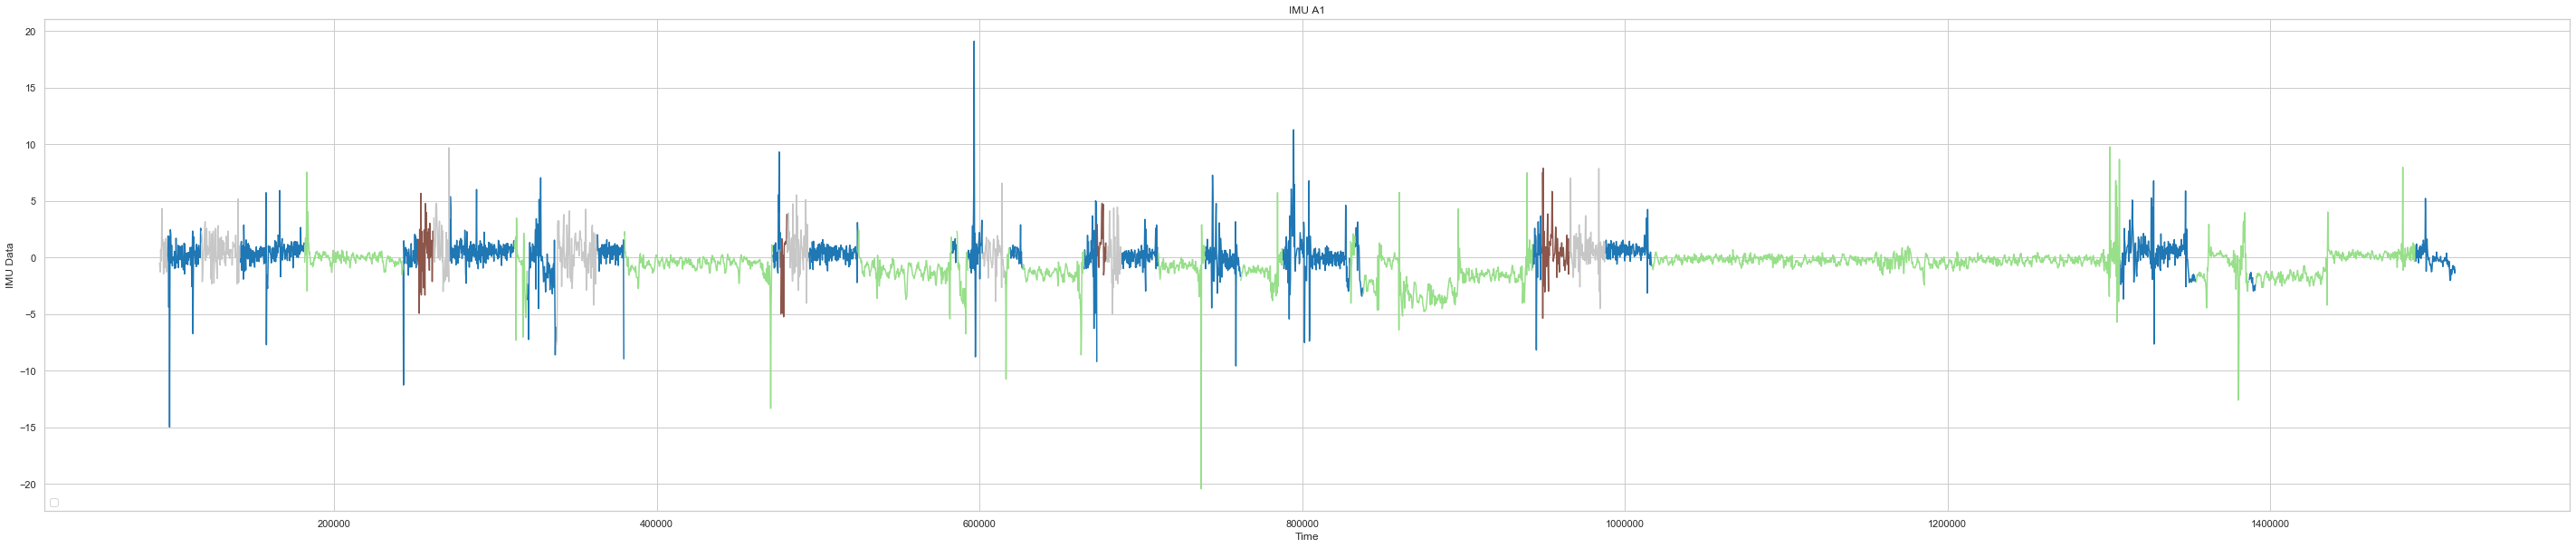

No handles with labels found to put in legend.


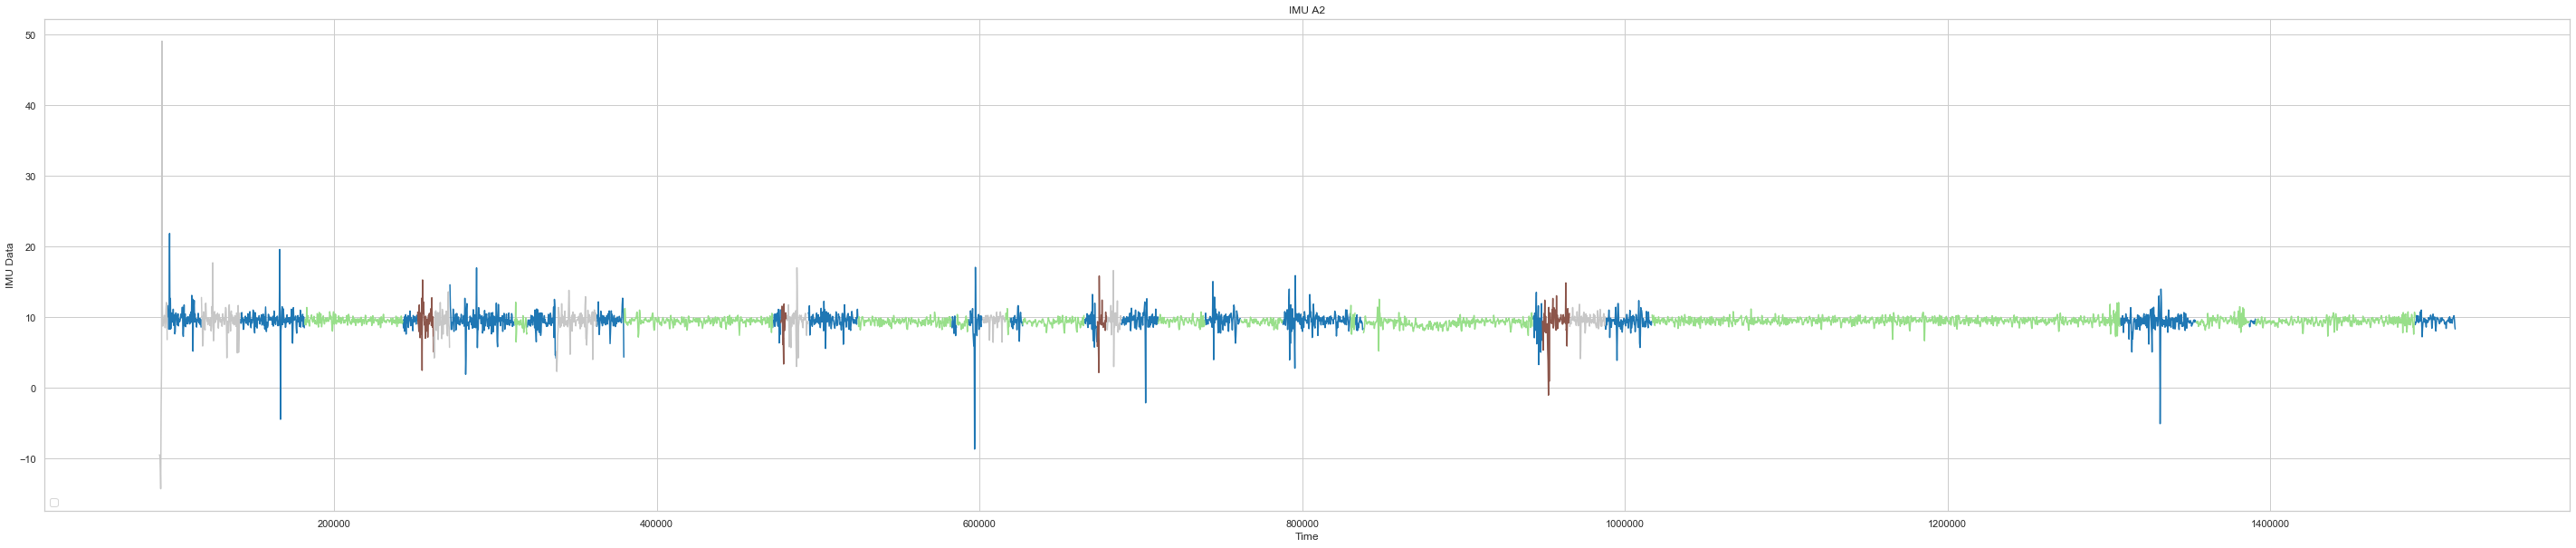

No handles with labels found to put in legend.


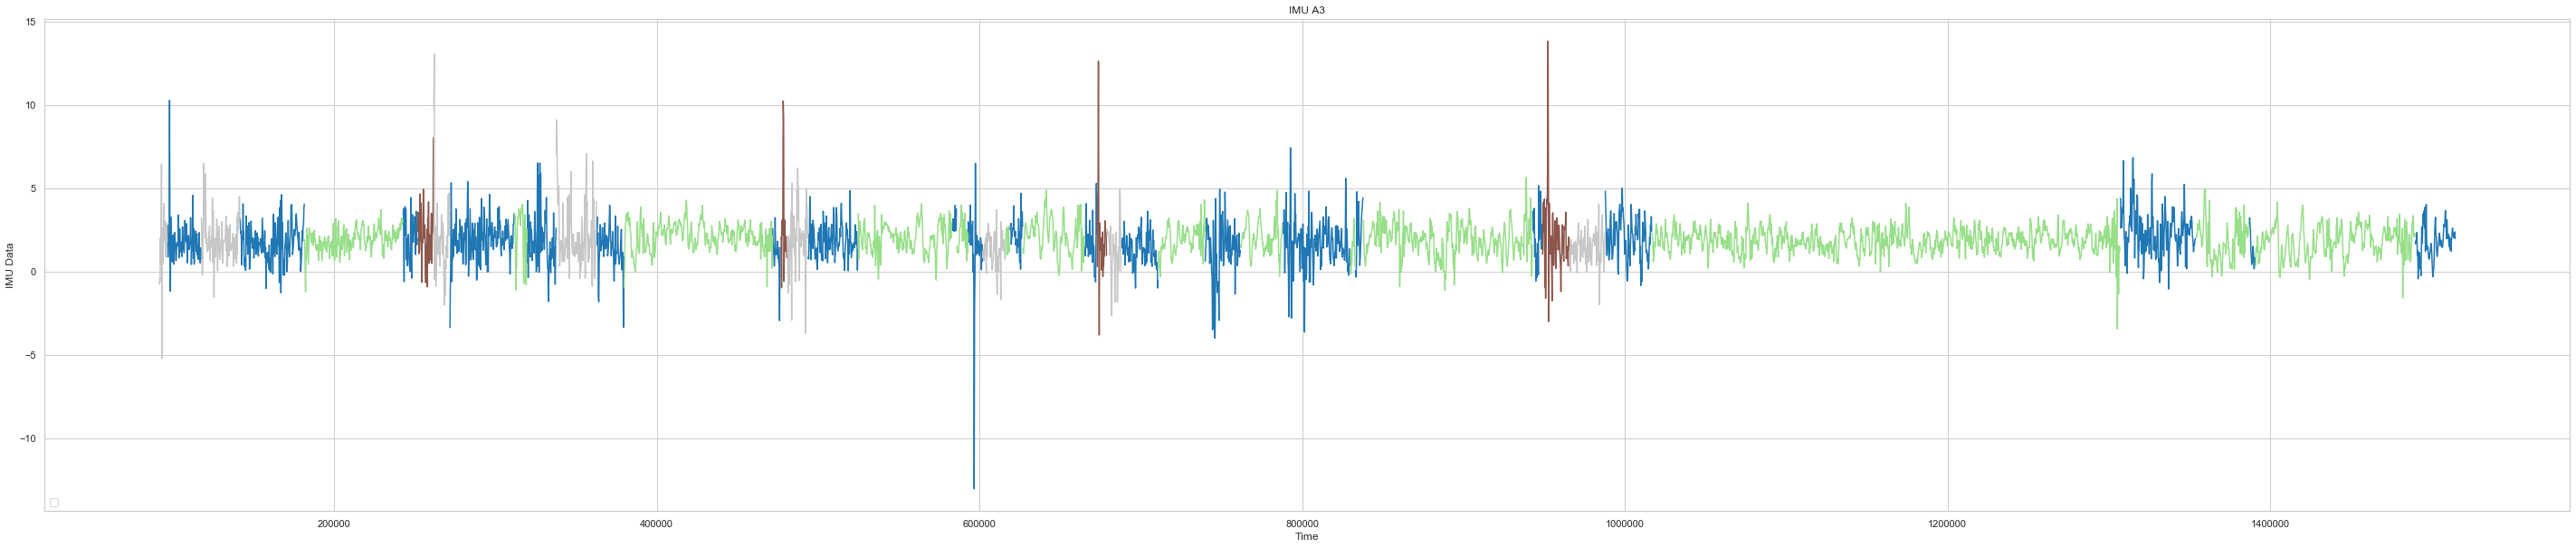

No handles with labels found to put in legend.


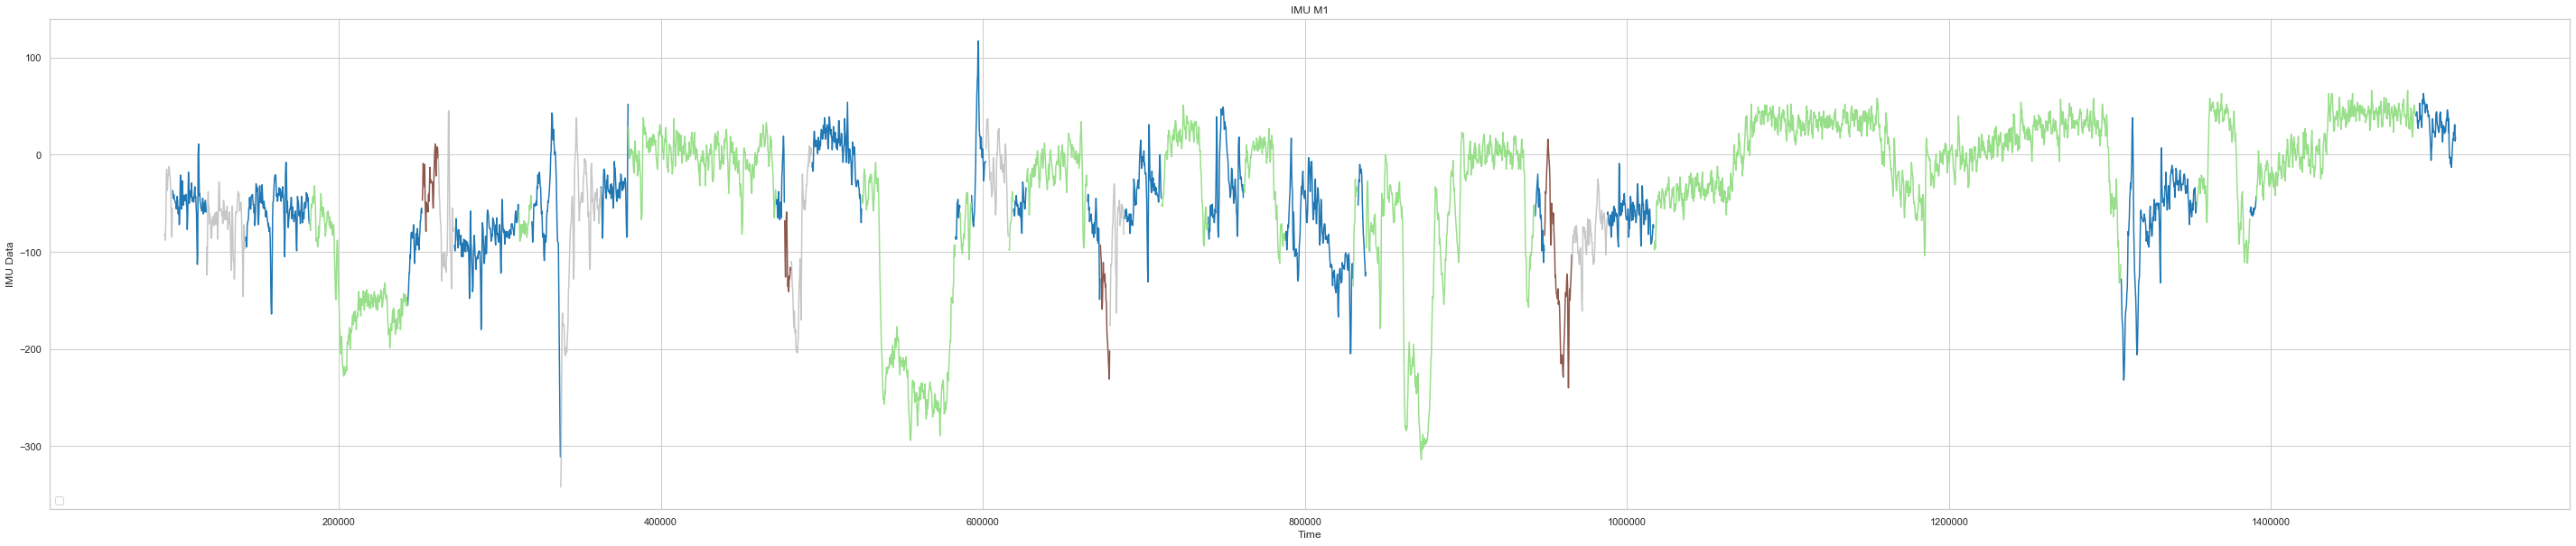

No handles with labels found to put in legend.


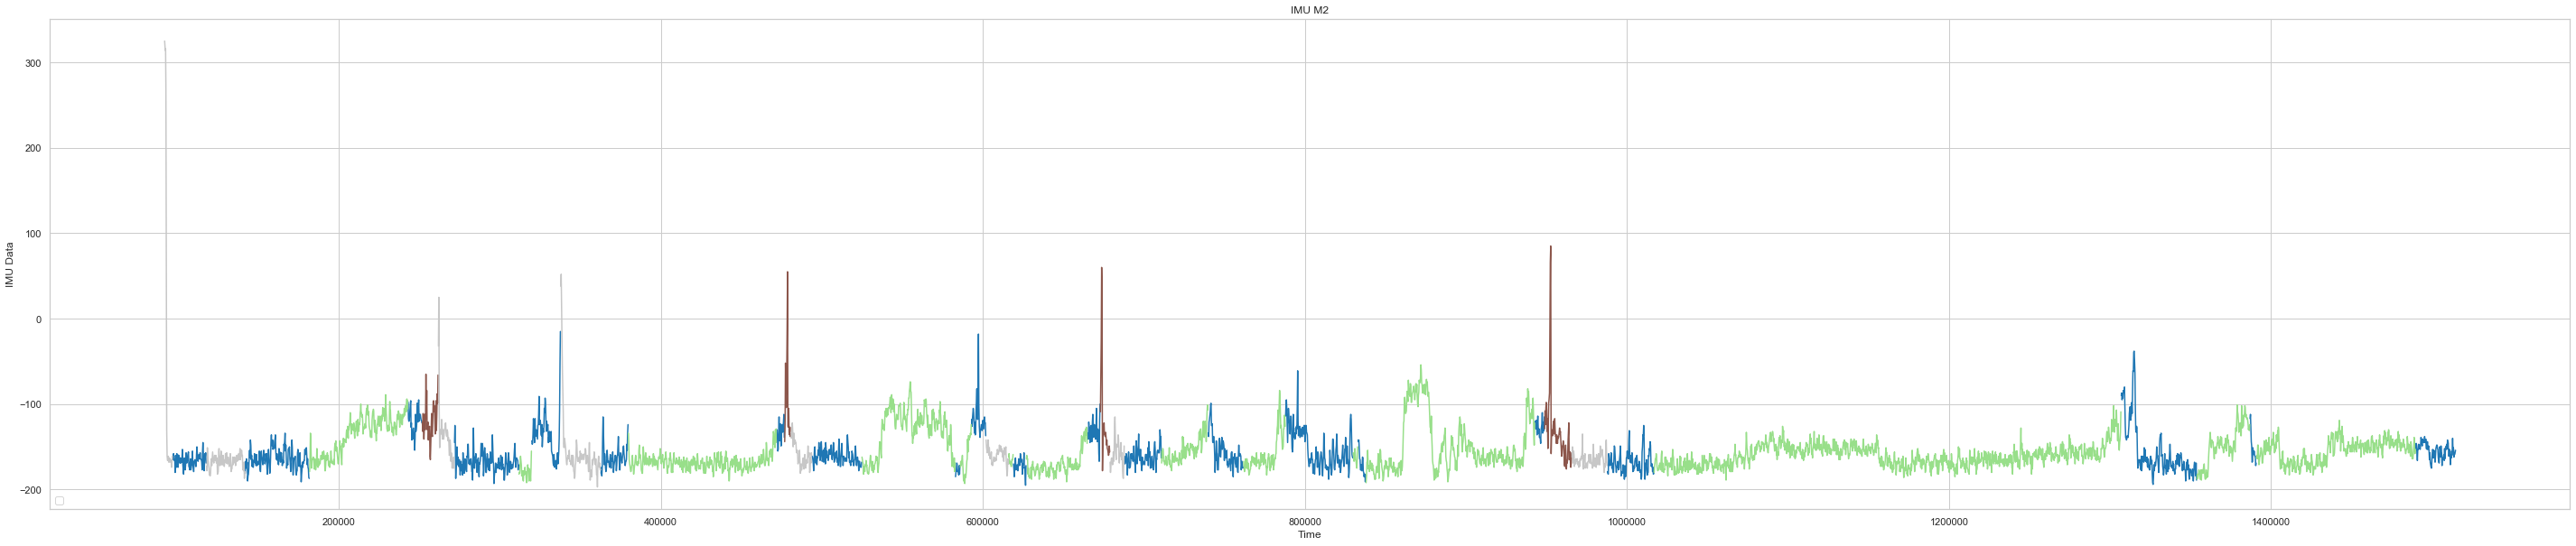

No handles with labels found to put in legend.


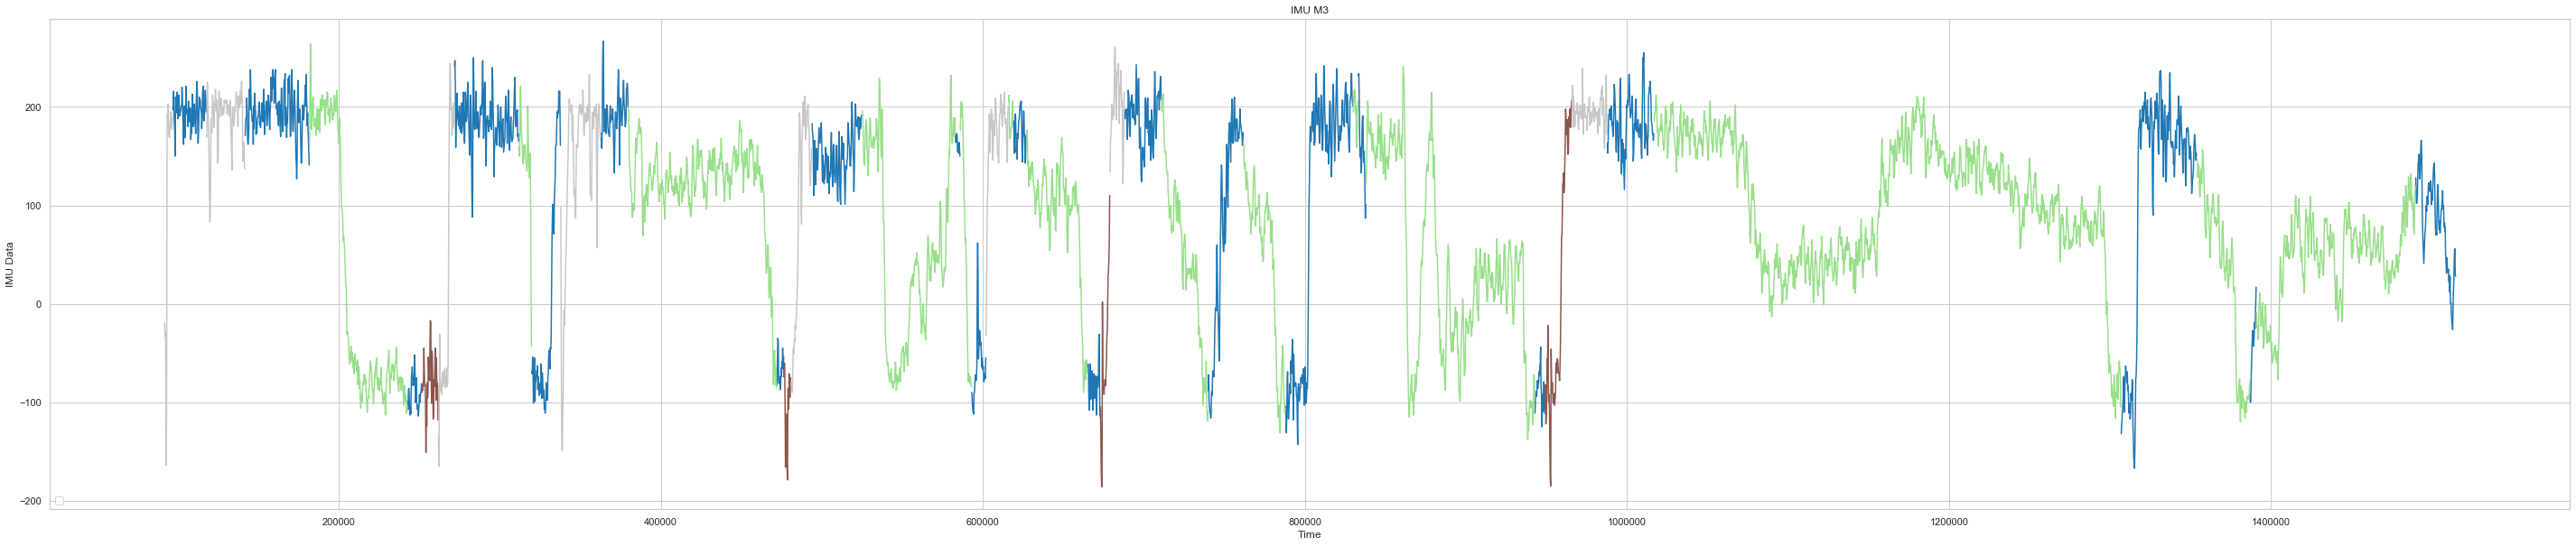

Done


In [15]:
#For plotting, just comment out the "concatenation" lines. 

#Need to clear kernel and then only run all above so that it plots on axes directly below, rather than on another plot
print("Creating Plots...")
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
#createPlot(df_converted,'IMU G1')
#createPlot(df_converted,'IMU G2')
#createPlot(df_converted,'IMU G3')
createPlot(df_converted,'IMU M1')
createPlot(df_converted,'IMU M2')
createPlot(df_converted,'IMU M3')

print("Done")


### Instead of looking at all labels, just look at floating vs. not floating: 

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'PADDLING', 'FLOATING', 'SURFING', 'WALKING']
21645


No handles with labels found to put in legend.


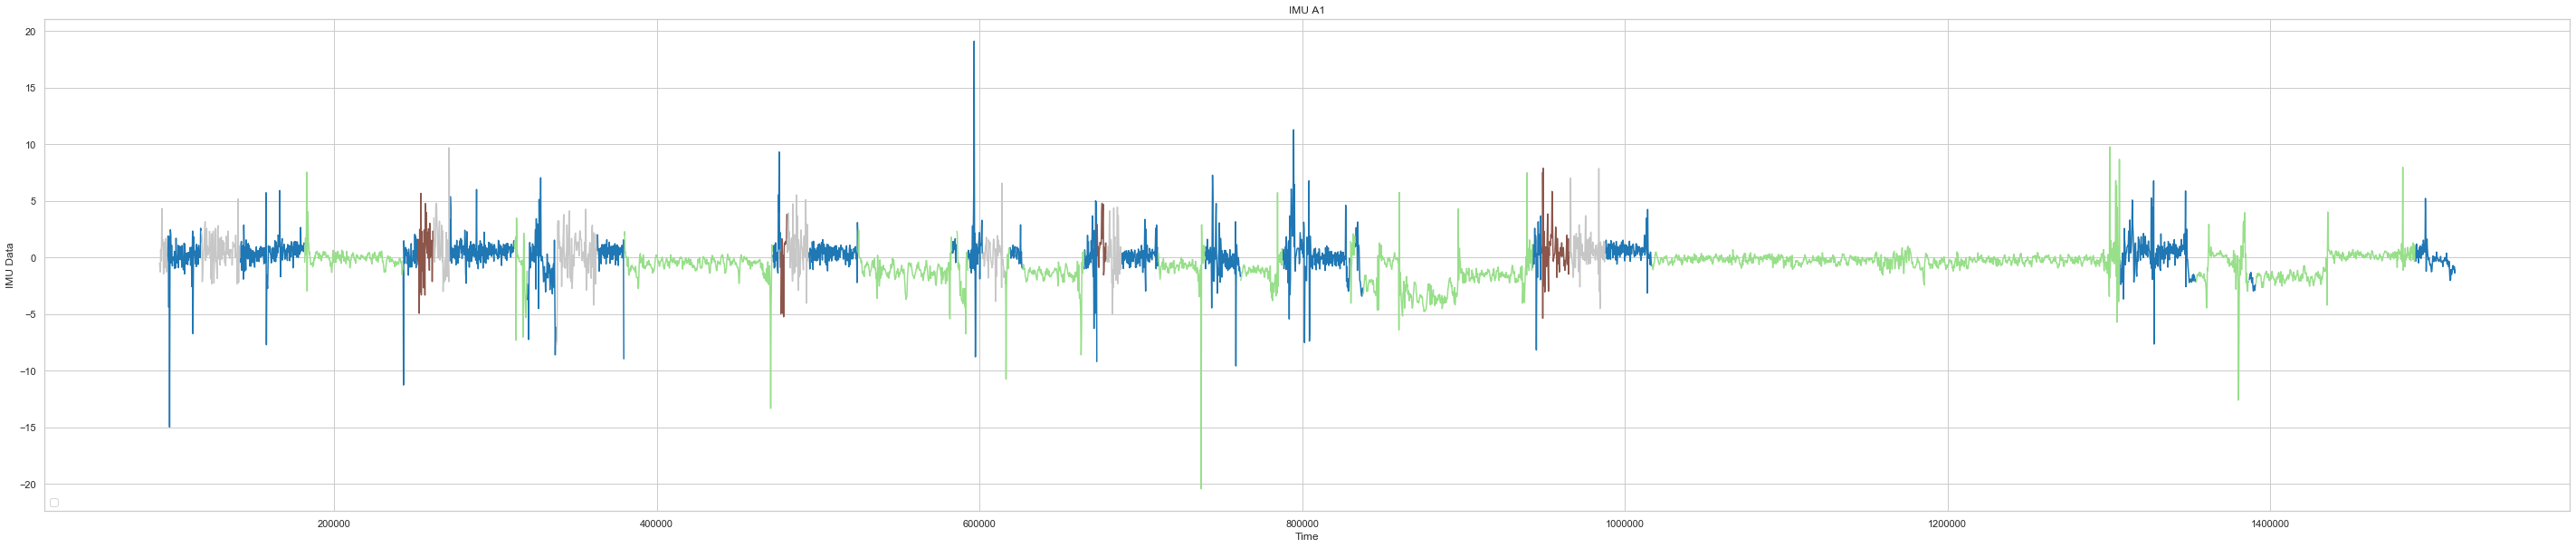

21645


In [17]:
print(list(df_converted.columns))
print(len(df_converted))



drop_list = ['SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'POP-UP', 'SURFING', 'STEP-OFF', "TURNING TO SURFER'S RIGHT", 'SIT-BACK', 'OFF-BOARD', 'PADDLING', 'WIPE-OUT', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'DISCARD', 'WALKING OUT OF WATER', 'PADDLING', 'WALKING']
for x in drop_list: 
    if x in df_converted.columns:
        df_converted = df_converted.drop(columns=[x])
                                          
print(len(df_converted))                                       
                                          
                                          

Creating Plots...


No handles with labels found to put in legend.


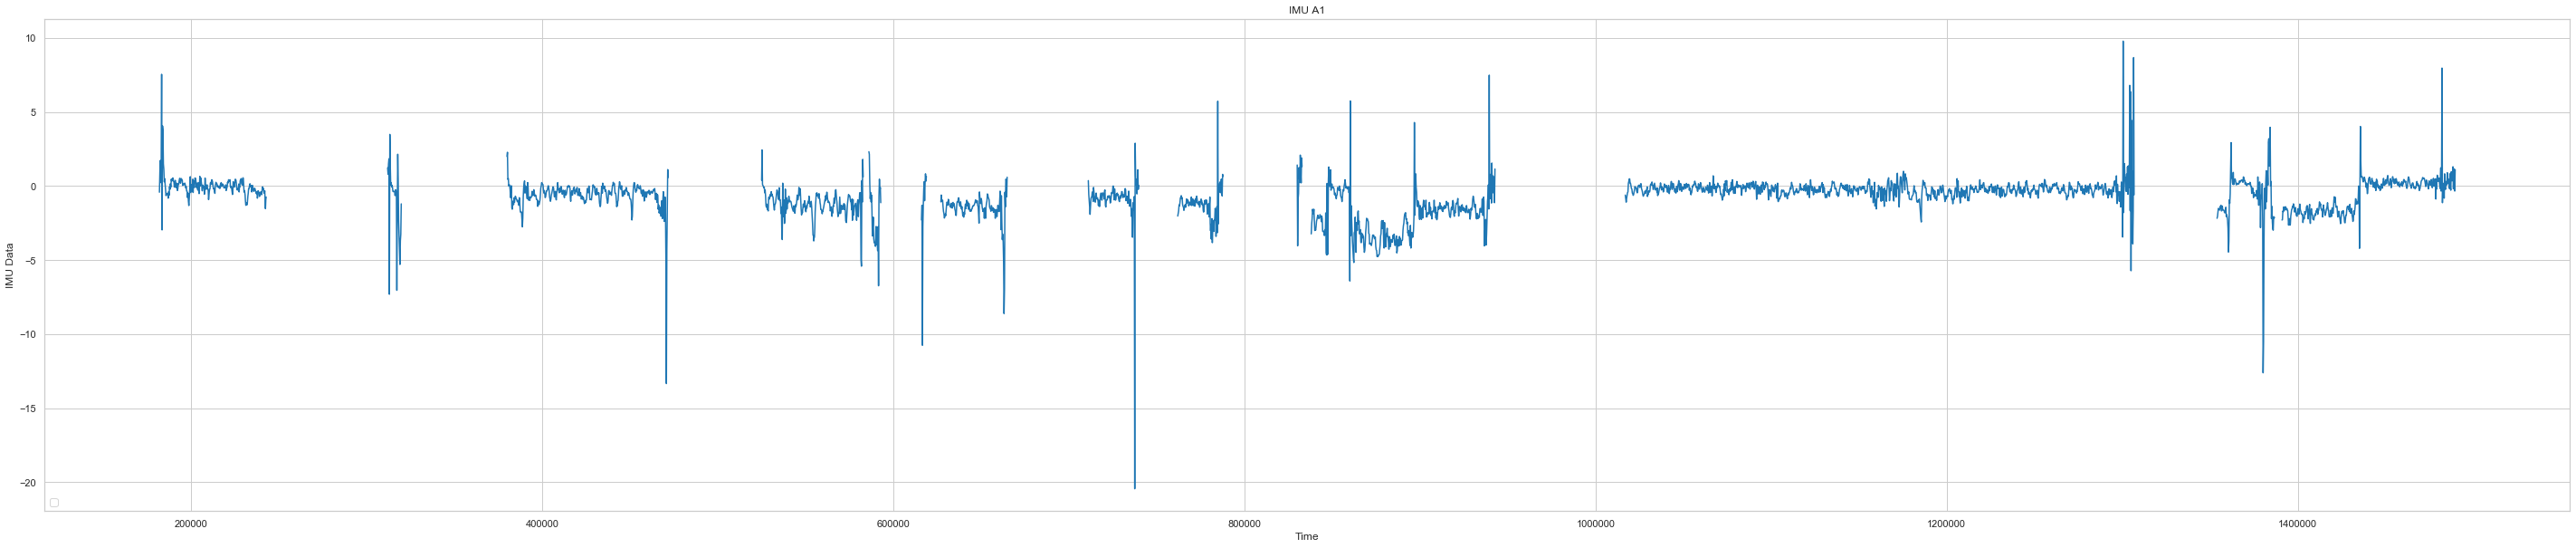

No handles with labels found to put in legend.


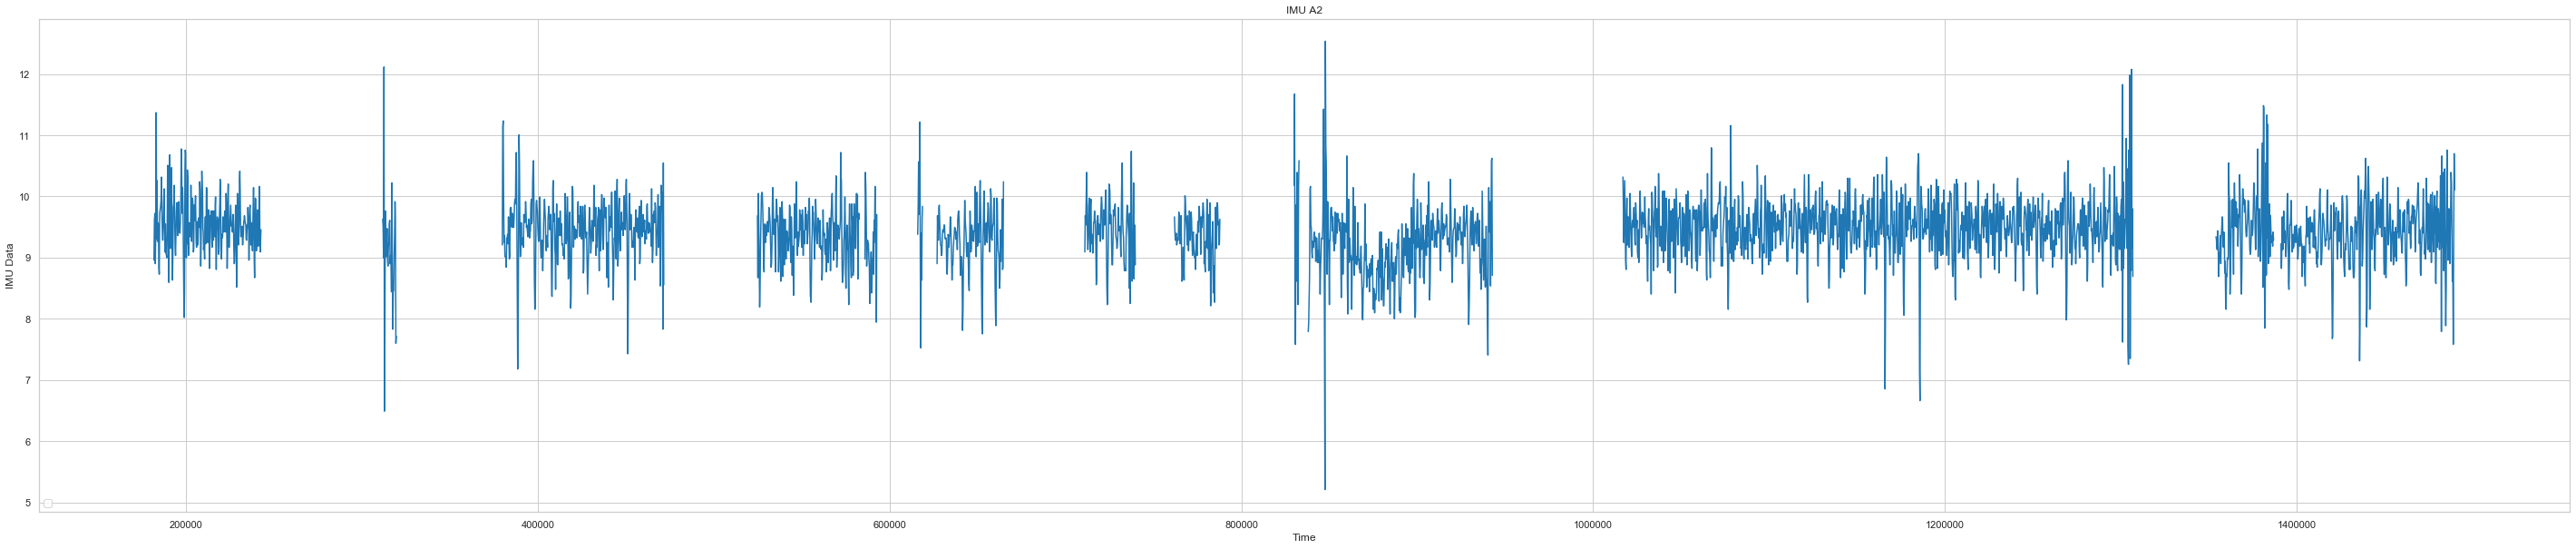

No handles with labels found to put in legend.


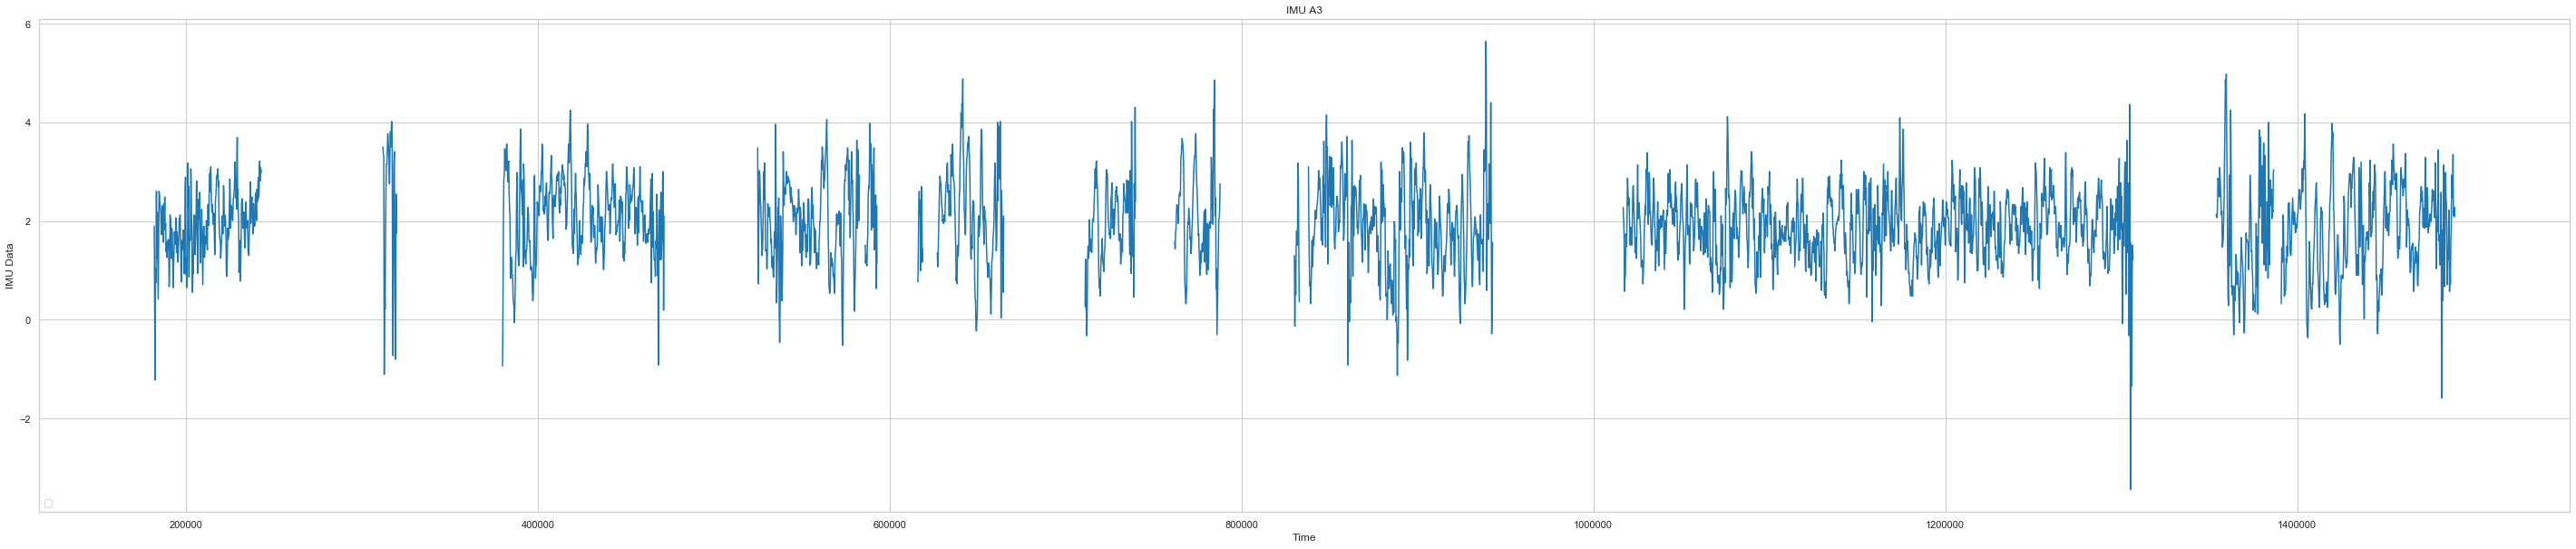

In [18]:

print("Creating Plots...")
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')

In [ ]:
#df_converted["IMU A2"]
df_converted["TimeDelta"]

### Now we can try analyzing a "floating" time-slice in the middle of this data: 

In [ ]:
#Look at IMU A2 time-slice from 1,050,000 to 1,300,000:

keys = df_converted["TimeDelta"].values
values = df_converted["IMU A2"].values
imu_a2_time_dict = dict(zip(keys, values))

print(type(keys))
print(type(values))

#Now need to slice the dictionary into 2 new lists: 
time_slice = []
imu_a2_slice = []
for time in imu_a2_time_dict:
    if time > 1050000.0 and time < 1300000.0:
        time_slice.append(float(time))
        #print(imu_a2_time_dict[time] - 9.80665)
        #Need to also subtract gravity from IMU A2 value:
        imu_a2_slice.append(float(imu_a2_time_dict[time]) - 9.80665)
        
#print(type(time_slice))
#print(imu_a2_slice)

In [ ]:
#import matplotlib.pyplot as plt
#import pylab
#%matplotlib inline

print("Plot not showing up for some reason - axis tick issue?")

plt.plot(time_slice, imu_a2_slice)
#plt.xticks=(np.arange(1050000, 1300000, step=50000))
plt.xlabel('Time Elapsed [ms]')
plt.ylabel('IMU A2')

plt.show()

## Perform Wave Train Analysis on Floating Data

### Steps 1 & 2: Detrend and filter the data

In [ ]:
#Step 1. Detrend data
from scipy import signal
dacc_array = signal.detrend(imu_a2_slice)
time_array = time_slice
f_s = 4.0 #sampling frequency

In [ ]:

#First integral of acc to get velocity:
from scipy import integrate

def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t > low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array

    

In [ ]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


### Step 3. Remove outliers larger than 3x the standard deviation:

In [ ]:
#Removes outliers from the array (outliers = values larger than 3x the standard deviation) and replaces them with the mean value.

def func_remove_outliers(acc_array):
    updated_acc_array = []
    std = np.std(acc_array)
    #print("Std: ", std)
    mean = np.median(acc_array)
    #print("Mean: ", mean)
    for value in acc_array:
        if value > mean + 3*std:
            #print("Value is:", value)
            value = mean
        elif value < -mean - 3*std:
            value = -mean
        updated_acc_array.append(value)
    
    return updated_acc_array

In [ ]:
# Define the sample rate and the Low and High Cutoff frequencies

fs = 4.0 #redefine the sampling frequency

order= 6
lowcut = 0.09
highcut = 1.0

def double_integral_bandpass(time_array, acc_array, dacc_array, lowcut, highcut, fs, order):
    
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)



    f1 = plt.figure(figsize=(12,5))
    ax1 = f1.add_subplot(121)
    ax2 = f1.add_subplot(122)

    f2 = plt.figure(figsize=(12,5))
    ax3 = f2.add_subplot(121)
    ax4 = f2.add_subplot(122)
    
    f3 = plt.figure(figsize=(12,5))
    ax5 = f3.add_subplot(121)
    ax6 = f3.add_subplot(122)

    #Acceleration graphs:
    ax1.plot(time_array, dacc_array)
    ax1.set_title('Detrended Acceleration vs. Time')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Acceleration [m/s^2]')
    ax1.axhline(0, color="orange", ls='--')
    
    ax2.plot(time_array, butter_lfilter)
    ax2.set_title('Butter Filtered Detrended Acceleration vs. Time')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Acceleration [m/s^2]')
    ax2.axhline(0, color="orange", ls='--')
    
    #Velocity graphs:
    ax3.plot(time_array, v_butter_filter_integral)
    ax3.set_title('Butter Filtered Velocity vs. Time')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Velocity [m/s]')
    ax3.axhline(0, color="orange", ls='--')


    ax4.plot(time_array, detrend_v_integral)
    ax4.set_title('Butter Filtered Detrended Velocity vs. Time')
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Velocity [m/s]')
    ax4.axhline(0, color="orange",ls='--')

    
    #Displacement graphs:
    ax5.plot(time_array, disp_butter_filter_integral)
    ax5.set_title('Butter Filtered Displacement vs. Time')
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Displacement [m]')               
    
    ax6.plot(time_array, detrend_disp_butter_integral)
    ax6.set_title('Detrended Butter Filtered Displacement vs. Time')
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Displacement [m]')


    plt.show()
    
    return detrend_disp_butter_integral

print(dacc_array)
    
    
##For subexperiment1:
print("Starting subexperiment 1 analysis:")
#Get as close to just the signal (don't want noise)    
new_t1, new_acc1 = calculate_new_range(df_converted["TimeDelta"].values, df_converted["IMU A2"].values, 1050000.0, 1300000.0)    
#new_t1, new_dacc1 = calculate_new_range(time_slice, dacc_array1, 0, 800)
new_acc1 = func_remove_outliers(new_acc1)
new_dacc1 = signal.detrend(new_acc1)

for i in range(0, len(new_t1)):
    t = new_t1[i] - 1050000.0
    new_t1[i] = t*.001

disp_butter_integral1 = double_integral_bandpass(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs, order)
print("Done.")

print(new_acc1[0:10])
print(new_dacc1[0:10])
print(new_t1[0:10])


## Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.
print("Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.")

In [ ]:
new_dacc1 = disp_butter_integral1

## Peak Picking Algorithm:

In [ ]:
#First, find peaks and valleys of the waveforms:
#(Found that this works better when the data has been detrended.)

#Need to convert to numpy array types: 
new_dacc1 = np.array(new_dacc1)
new_t1 = np.array(new_t1)


indexes0 = peakutils.indexes(new_dacc1, thres=0.02/max(new_dacc1), min_dist=100)

col_0t = new_t1 # First column data
col_0a = new_dacc1 # Second column data


#Index1 gets the peaks, while index2 gets the valleys
index_max0 = peakutils.indexes(col_0a, thres=0.66, min_dist=25)
index_min0 = peakutils.indexes(-col_0a, thres=0.66, min_dist=25)



##Plotting:
f1 = plt.figure(figsize=(12,5))
ax1 = f1.add_subplot(111)



ax1.plot(col_0t,col_0a, lw=0.4, alpha=1.0, color='black' )
#ax1.plot(col_0t[index_max0],col_0a[index_max0], marker="o", ls="", ms=3, color="red" )
#ax1.plot(col_0t[index_min0],col_0a[index_min0], color ="orange", marker="o", ls="", ms=3 )
ax1.set_title("Vertical Displacement vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Displacement [m]')
#ax1.axhline(0, color="orange", ls='--')
#ax1.axhline(0.3, color="green", ls='-')
#ax1.axhline(-0.3, color="green", ls='-')
#ax1.axhline(0.6, color="red", ls='-')
#ax1.axhline(-0.6, color="red", ls='-')




plt.show()


In [ ]:
#According to historic CDIP data: 
#http://cdip.ucsd.edu/offline/wavecdf/wnc_browse.php?ARCHIVE/201p1/201p1_historic+waveHs+201811
print("Expecting significant wave height between 0.5 and 0.7m")
print("Expecting wave period between 7s and 12s")

In [ ]:
### Choose the tallest 1/3 of waves to observe, then take the mean of that subset: 

In [ ]:
#Calculating significant wave height by doing analysis over entire wave (not just max peaks picked):
print("Number of datapoints: ", len(new_dacc1))

n = int(len(new_dacc1)/3)

print("Number of datapoints divided by 3: ", n)
print("\n")

x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
largest_third = (x0[np.argsort(x0)[-n:]])

#print(largest_third)

print("Mean of largest third of waves: ", np.mean(largest_third))
wave_height = 2*np.mean(largest_third)

expected_SWH = 0.6
print("Expecting Significant wave height between 0.5 and 0.7m.")
print("Significant wave height calculated as: ", wave_height)
print("SWH Percentage Error: ", abs(expected_SWH-wave_height)/expected_SWH)

## Starting Spectral Analysis

### Using Displacement Data: 

In [ ]:
from scipy import signal
f_s = 4.0

##PSD Step 2: Detrend the data 
#dacc_array = signal.detrend(new_dacc1)
dacc_array = new_dacc1

#Taking the FFT of acceleration:
fft_acc = np.fft.fft(dacc_array)
len_fft_acc = len(fft_acc)
freq_acc = np.fft.fftfreq(len_fft_acc, 1/f_s)

#Shifting the FFT of acceleration:
fft_acc_shifted = np.fft.fftshift(fft_acc)
freq_acc_shifted = np.fft.fftshift(freq_acc)

#Normalize:
fft_acc_normal = np.abs(fft_acc_shifted/len_fft_acc)*2


#Now, multiply the accelerations by 1/w^2 to get the displacement in the frequency domain:

f = abs(freq_acc_shifted[np.argmax(fft_acc_normal)])
#print(f)

w = 2*np.pi*f
omega = 1/w**2

disp_normal = []

for a in fft_acc_normal:
    new_a = a*omega
    disp_normal.append(new_a)

#So now disp_normal should have the new values, 
#representing displacement in the frequency domain.

print("\n")

#Calculating wave statistics
peak_freq = np.abs(freq_acc_shifted[np.argmax(fft_acc_normal)])
print("Smartfin Peak Frequnecy: ", peak_freq)

CDIP_peak_freq = 1.0/9.5
print("CDIP Peak Frequnecy: ", CDIP_peak_freq)

print("Frequency Standard Error: ", abs(CDIP_peak_freq-peak_freq)/CDIP_peak_freq)

peak_period = float(1/peak_freq)
CDIP_peak_period = 9.5

print("\n")

print("Smartfin Peak Period: ", peak_period)
print("CDIP Peak Period: ", CDIP_peak_period)
print("Period Standard Error: ", abs(CDIP_peak_period-peak_period)/CDIP_peak_period)



#representing displacement in the frequency domain.
fig = plt.figure(num=None, figsize=(6,3), dpi=80, facecolor='w', edgecolor='k')

# Returns the Axes instance
ax = fig.add_subplot(111) 


ax.plot(freq_acc_shifted, fft_acc_normal)
ax.set_title("Displacement in the Frequency Domain")
ax.set_xlabel('Frequency [Hz]')
plt.xlim(0,1)
plt.ylim(0,)
plt.xticks(np.arange(0,1, step=.1))

plt.show()